# Tutorial for the montecarlo python package

Copyright 2016, Vinothan N. Manoharan, Victoria Hwang, Annie Stephenson

This file is part of the structural-color python package.

This package is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This package is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this package. If not, see http://www.gnu.org/licenses/.

## Loading and using the package

To load, make sure you are in the top directory and do

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import structcol as sc
import structcol.refractive_index as ri
from structcol import montecarlo as mc

# For Jupyter notebooks only:
%matplotlib inline

## Run photon packets in parallel plane medium

This is an example code to run a Monte Carlo calculation for photon packets travelling in a scattering medium.

Set random number seed.  This is so that the code produces the same trajectories each time (for testing purposes).  Comment this out or set the seed to `None` for real calculations.

In [2]:
seed = 1

In [3]:
# Properties of system

ntrajectories = 50                     # number of trajectories
nevents = 100                           # number of scattering events in each trajectory
wavelen = sc.Quantity('600 nm')
radius = sc.Quantity('0.125 um')
volume_fraction = 0.5
n_particle = 1.54
n_matrix = ri.n('vacuum', wavelen)
n_sample = ri.n_eff(n_particle, n_matrix, volume_fraction)

# scattering angles for the phase function calculation (typically from 0 to pi)
angles = sc.Quantity(np.linspace(0,np.pi, 200), 'rad')   

In [4]:
#%%timeit
# Calculate the phase function and scattering and absorption lengths from mie.py
p = mc.phase_function(radius, n_particle, n_sample, angles, wavelen)
lscat, labs = mc.scat_abs_length(radius, n_particle, n_sample, volume_fraction, wavelen)

mua = 1 / labs                               # might be negative due to rounding error from mie.py
mus = 1 / lscat                              # scat coeff from Mie theory (only used in absorb function)

# Initialize the trajectories
r0, k0, W0 = mc.initialize(nevents, ntrajectories, seed=seed)
r0 = sc.Quantity(r0, 'um')
k0 = sc.Quantity(k0, '')
W0 = sc.Quantity(W0, '')

# Generate a matrix of all the randomly sampled angles first 
sintheta, costheta, sinphi, cosphi, theta, phi = mc.sampling(nevents, ntrajectories, p, angles)

# Create trajectories object
trajectories = mc.Trajectory(r0, k0, W0, nevents)


# Run photons
W = np.array(trajectories.absorb(mua, mus))                          
k = np.array(trajectories.scatter(sintheta, costheta, sinphi, cosphi))          
r = trajectories.move(lscat)

## Plot trajectories

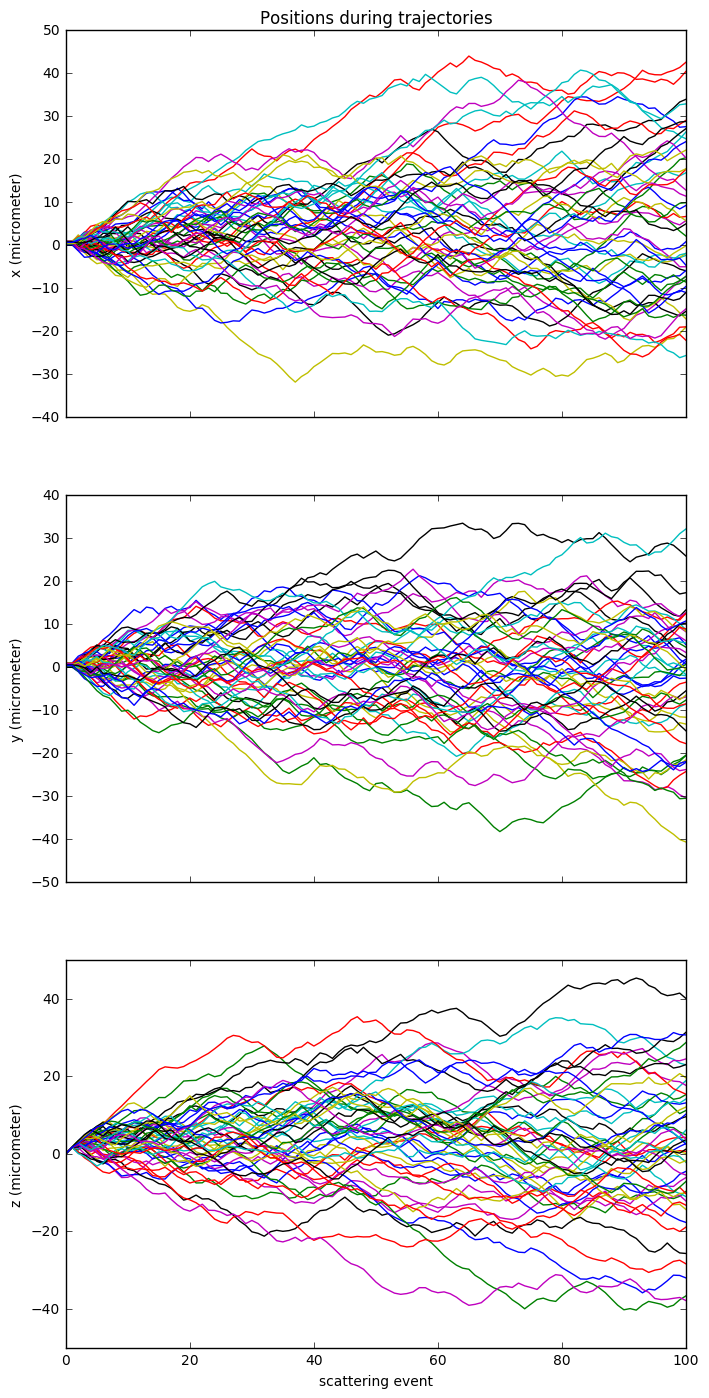

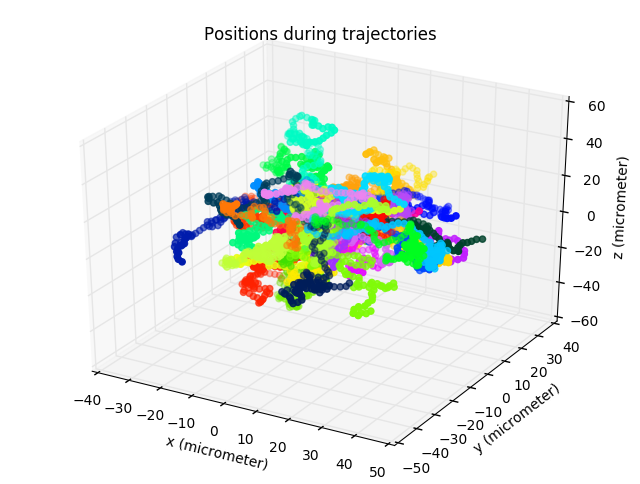

In [5]:
trajectories.plot_coord(ntrajectories, three_dim=True)

## Calculate the fraction of trajectories that are reflected

In [6]:
z_low = sc.Quantity('0.0 um')
cutoff = sc.Quantity('2. um')

R_fraction = mc.RTcounter(r[2], z_low, cutoff, ntrajectories, n_matrix, n_sample, k[0], k[1], k[2])[0]

print('R = '+ str(R_fraction))

R = 0.04
